# Medical Bill Detection with Faster R-CNN (PyTorch TorchVision)

This notebook implements training of a Faster R-CNN model using PyTorch's torchvision for detecting various elements in medical bills, including:
- Date of Receipt
- GSTIN
- Invoice Number
- Mobile Number
- Product Table
- Store Address
- Store Name
- Total Amount

The model will be trained using PyTorch's built-in Faster R-CNN implementation on the COCO-formatted dataset.

## 1. Setup Environment and Dependencies

First, we'll import all necessary libraries and check GPU availability.

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from datetime import datetime
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torchvision.transforms as T
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check PyTorch and CUDA setup
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"\nUsing device: {device}")

# Set the working directory to the dataset folder
os.chdir(os.path.dirname(os.path.abspath('__file__')))
print(f"Working directory: {os.getcwd()}")

PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA version: 12.1

Using device: cuda
Working directory: f:\Projects\docparse\models\faster-rcnn


## 2. Load and Explore Dataset

Let's analyze our COCO-formatted dataset configuration and structure.

In [2]:
# Load COCO annotations to understand the dataset
def load_coco_json(json_file):
    with open(json_file, 'r') as f:
        return json.load(f)

# Load training annotations
train_annotations = load_coco_json('train/_annotations.coco.json')
valid_annotations = load_coco_json('valid/_annotations.coco.json')
test_annotations = load_coco_json('test/_annotations.coco.json')

# Display dataset information
print("="*80)
print("DATASET INFORMATION")
print("="*80)

print("\nDataset Info:")
for key, value in train_annotations['info'].items():
    print(f"  {key}: {value}")

print("\nCategories/Classes:")
categories = train_annotations['categories']
print(f"Number of classes: {len(categories)}")
for cat in categories:
    print(f"  ID {cat['id']}: {cat['name']}")

print("\nDataset Split:")
print(f"Training images: {len(train_annotations['images'])}")
print(f"Validation images: {len(valid_annotations['images'])}")
print(f"Test images: {len(test_annotations['images'])}")
print(f"Total images: {len(train_annotations['images']) + len(valid_annotations['images']) + len(test_annotations['images'])}")

print("\nAnnotations:")
print(f"Training annotations: {len(train_annotations['annotations'])}")
print(f"Validation annotations: {len(valid_annotations['annotations'])}")
print(f"Test annotations: {len(test_annotations['annotations'])}")

# Store class names for later use
class_names = [cat['name'] for cat in categories]
num_classes = len(categories)

# Create category id to name mapping
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
print(f"\nClass names: {class_names}")

DATASET INFORMATION

Dataset Info:
  year: 2025
  version: 2
  description: Exported from roboflow.com
  contributor: 
  url: https://public.roboflow.com/object-detection/undefined
  date_created: 2025-10-26T19:15:30+00:00

Categories/Classes:
Number of classes: 9
  ID 0: images
  ID 1: date_of_reciept
  ID 2: gstin
  ID 3: invoice_no
  ID 4: mobile_no
  ID 5: product_table
  ID 6: store_address
  ID 7: store_name
  ID 8: total_amount

Dataset Split:
Training images: 742
Validation images: 60
Test images: 60
Total images: 862

Annotations:
Training annotations: 5904
Validation annotations: 477
Test annotations: 482

Class names: ['images', 'date_of_reciept', 'gstin', 'invoice_no', 'mobile_no', 'product_table', 'store_address', 'store_name', 'total_amount']


## 3. Create Custom Dataset Class

Define a PyTorch Dataset class to load COCO format data.

In [3]:
class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)
        
        self.images = coco_data['images']
        self.annotations = coco_data['annotations']
        self.categories = coco_data['categories']
        
        # Create image_id to annotations mapping
        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_info = self.images[idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        
        # Get annotations for this image
        img_id = img_info['id']
        anns = self.img_to_anns.get(img_id, [])
        
        # Prepare boxes, labels, and areas
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        
        for ann in anns:
            # COCO bbox format is [x, y, width, height]
            x, y, w, h = ann['bbox']
            # Convert to [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        
        # Apply transforms
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)
        
        return img, target

print("COCODataset class created successfully!")

COCODataset class created successfully!


## 4. Create Data Loaders

Set up data loaders for training, validation, and testing.

In [4]:
# Helper function for collating batches
def collate_fn(batch):
    return tuple(zip(*batch))

# Create datasets
train_dataset = COCODataset(
    root_dir='train',
    annotation_file='train/_annotations.coco.json'
)

valid_dataset = COCODataset(
    root_dir='valid',
    annotation_file='valid/_annotations.coco.json'
)

test_dataset = COCODataset(
    root_dir='test',
    annotation_file='test/_annotations.coco.json'
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Data loaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")

Data loaders created successfully!
Train batches: 186
Valid batches: 15
Test batches: 15


## 5. Visualize Sample Data

Let's visualize some sample images with their annotations.

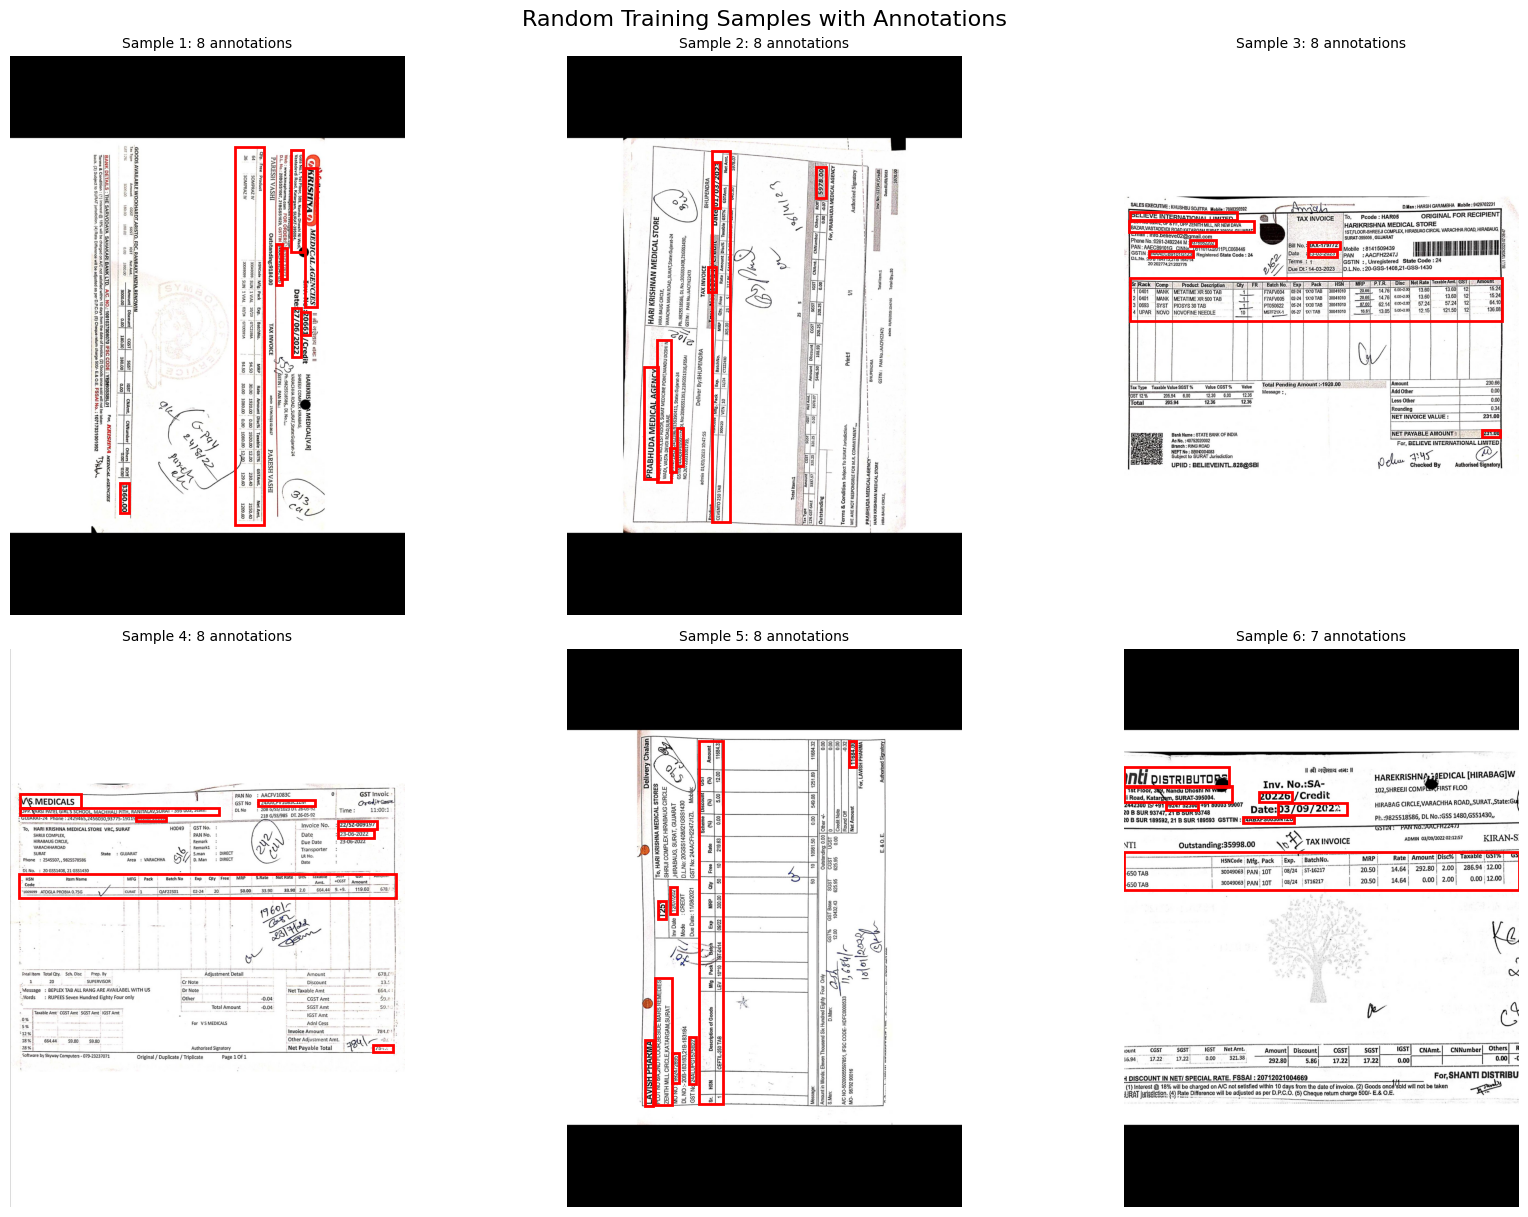


✓ Sample annotations visualized successfully!


In [5]:
def visualize_sample(dataset, idx, class_names):
    img, target = dataset[idx]
    
    # Convert tensor to numpy for visualization
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
    
    # Create figure
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    
    # Draw boxes and labels
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='red', linewidth=2
        )
        plt.gca().add_patch(rect)
        
        # Add label text
        label_name = class_names[label] if label < len(class_names) else f"Class {label}"
        plt.text(
            x1, y1 - 5, label_name,
            color='red', fontsize=10, weight='bold',
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.axis('off')
    plt.title(f"Sample {idx}: {len(boxes)} annotations", fontsize=12)
    return plt

# Visualize random samples
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    random_idx = random.randint(0, len(train_dataset) - 1)
    img, target = train_dataset[random_idx]
    
    # Convert tensor to numpy
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
    
    ax.imshow(img)
    
    # Draw boxes
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor='red', linewidth=2
        )
        ax.add_patch(rect)
    
    ax.axis('off')
    ax.set_title(f"Sample {idx + 1}: {len(boxes)} annotations", fontsize=10)

plt.tight_layout()
plt.suptitle('Random Training Samples with Annotations', fontsize=16, y=1.01)
plt.show()

print("\n✓ Sample annotations visualized successfully!")

## 6. Create Faster R-CNN Model

Initialize the Faster R-CNN model with a ResNet-50 FPN backbone.

In [5]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create model
model = get_model(num_classes)
model.to(device)

print("Faster R-CNN Model created successfully!")
print(f"\nModel Configuration:")
print(f"  Architecture: Faster R-CNN with ResNet-50 FPN")
print(f"  Number of classes: {num_classes}")
print(f"  Device: {device}")
print(f"\nModel loaded with pre-trained weights from COCO dataset")

Faster R-CNN Model created successfully!

Model Configuration:
  Architecture: Faster R-CNN with ResNet-50 FPN
  Number of classes: 9
  Device: cuda

Model loaded with pre-trained weights from COCO dataset


## 7. Setup Training Configuration

Configure optimizer, learning rate scheduler, and training parameters.

In [6]:
# Training parameters
num_epochs = 25
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
lr_step_size = 10
lr_gamma = 0.1

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=lr_step_size,
    gamma=lr_gamma
)

print("Training Configuration:")
print(f"  Number of epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Momentum: {momentum}")
print(f"  Weight decay: {weight_decay}")
print(f"  LR step size: {lr_step_size}")
print(f"  LR gamma: {lr_gamma}")
print(f"\nOptimizer and scheduler configured successfully!")

Training Configuration:
  Number of epochs: 25
  Learning rate: 0.005
  Momentum: 0.9
  Weight decay: 0.0005
  LR step size: 10
  LR gamma: 0.1

Optimizer and scheduler configured successfully!


## 8. Training Functions

Define functions for training and evaluation.

In [7]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    
    epoch_loss = 0
    loss_dict_reduced_sum = {}
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch}")
    
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Track losses
        epoch_loss += losses.item()
        
        # Accumulate loss components
        for key, value in loss_dict.items():
            if key not in loss_dict_reduced_sum:
                loss_dict_reduced_sum[key] = 0
            loss_dict_reduced_sum[key] += value.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{losses.item():.4f}',
            'avg_loss': f'{epoch_loss / (pbar.n + 1):.4f}'
        })
    
    # Calculate average losses
    avg_loss = epoch_loss / len(data_loader)
    avg_loss_components = {k: v / len(data_loader) for k, v in loss_dict_reduced_sum.items()}
    
    return avg_loss, avg_loss_components


@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    
    # Store predictions and ground truth
    all_predictions = []
    all_targets = []
    
    pbar = tqdm(data_loader, desc="Evaluating")
    
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        
        # Get predictions
        predictions = model(images)
        
        # Move predictions to CPU
        predictions = [{k: v.cpu() for k, v in pred.items()} for pred in predictions]
        
        all_predictions.extend(predictions)
        all_targets.extend(targets)
    
    return all_predictions, all_targets

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


## 9. Train the Model

Now let's train the Faster R-CNN model on our medical bill detection dataset.

In [ ]:
# Create output directory
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Training history
history = {
    'epoch': [],
    'train_loss': [],
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_objectness': [],
    'loss_rpn_box_reg': [],
    'learning_rate': []
}

print("="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Training on {len(train_dataset)} images")
print(f"Validating on {len(valid_dataset)} images")
print(f"Device: {device}")
print("="*80)

best_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    # Train for one epoch
    avg_loss, loss_components = train_one_epoch(
        model, optimizer, train_loader, device, epoch
    )
    
    # Update learning rate
    lr_scheduler.step()
    
    # Record history
    history['epoch'].append(epoch)
    history['train_loss'].append(avg_loss)
    history['loss_classifier'].append(loss_components.get('loss_classifier', 0))
    history['loss_box_reg'].append(loss_components.get('loss_box_reg', 0))
    history['loss_objectness'].append(loss_components.get('loss_objectness', 0))
    history['loss_rpn_box_reg'].append(loss_components.get('loss_rpn_box_reg', 0))
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    
    # Print epoch summary
    print(f"\nEpoch {epoch}/{num_epochs}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Classifier Loss: {loss_components.get('loss_classifier', 0):.4f}")
    print(f"  Box Regression Loss: {loss_components.get('loss_box_reg', 0):.4f}")
    print(f"  RPN Objectness Loss: {loss_components.get('loss_objectness', 0):.4f}")
    print(f"  RPN Box Reg Loss: {loss_components.get('loss_rpn_box_reg', 0):.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, output_dir / 'best_model.pth')
        print(f"  ✓ Best model saved! (loss: {best_loss:.4f})")
    
    # Save checkpoint every 5 epochs
    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, output_dir / f'checkpoint_epoch_{epoch}.pth')
        print(f"  ✓ Checkpoint saved at epoch {epoch}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, output_dir / 'final_model.pth')

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(output_dir / 'training_history.csv', index=False)

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"Best loss: {best_loss:.4f}")
print(f"Models saved to: {output_dir}")

## 10. Visualize Training Progress

Plot the training loss curves to understand model convergence.

NameError: name 'history' is not defined

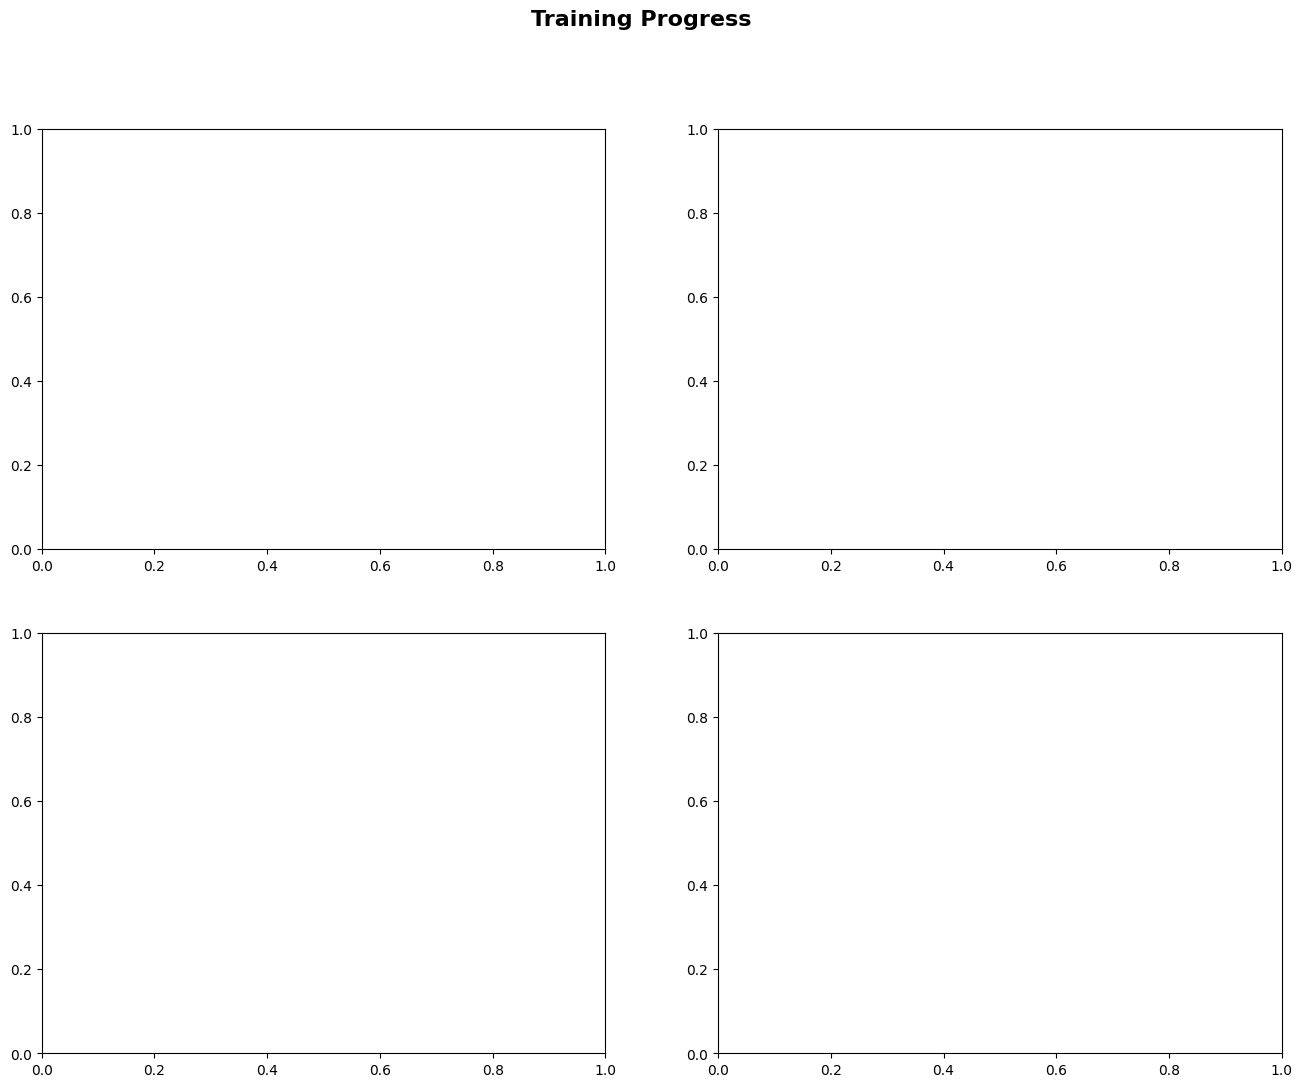

In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Progress', fontsize=16, fontweight='bold')

# Plot 1: Total Loss
ax = axes[0, 0]
ax.plot(history['epoch'], history['train_loss'], linewidth=2, color='#2E86AB', marker='o')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Total Loss', fontsize=12)
ax.set_title('Total Training Loss', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Classification and Box Regression Losses
ax = axes[0, 1]
ax.plot(history['epoch'], history['loss_classifier'], linewidth=2, color='#A23B72', marker='o', label='Classifier')
ax.plot(history['epoch'], history['loss_box_reg'], linewidth=2, color='#06A77D', marker='s', label='Box Reg')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Classification & Box Regression Losses', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: RPN Losses
ax = axes[1, 0]
ax.plot(history['epoch'], history['loss_objectness'], linewidth=2, color='#F18F01', marker='o', label='Objectness')
ax.plot(history['epoch'], history['loss_rpn_box_reg'], linewidth=2, color='#E63946', marker='s', label='RPN Box Reg')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Region Proposal Network Losses', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Learning Rate
ax = axes[1, 1]
ax.plot(history['epoch'], history['learning_rate'], linewidth=2, color='#457B9D', marker='o')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Learning Rate', fontsize=12)
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(output_dir / 'training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training progress visualizations saved!")

## 11. Evaluate on Validation Set

Load the best model and evaluate on the validation set.

In [ ]:
# Load best model
checkpoint = torch.load(output_dir / 'final_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print(f"Best model loaded from epoch {checkpoint['epoch']}")

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_predictions, val_targets = evaluate(model, valid_loader, device)

# Calculate basic statistics
total_predictions = sum(len(pred['boxes']) for pred in val_predictions)
total_ground_truth = sum(len(target['boxes']) for target in val_targets)

print("\n" + "="*80)
print("VALIDATION RESULTS")
print("="*80)
print(f"Total images: {len(val_predictions)}")
print(f"Total predictions: {total_predictions}")
print(f"Total ground truth boxes: {total_ground_truth}")
print(f"Average predictions per image: {total_predictions / len(val_predictions):.2f}")
print(f"Average ground truth boxes per image: {total_ground_truth / len(val_targets):.2f}")
print("="*80)

FileNotFoundError: [Errno 2] No such file or directory: 'weights\\best_model.pth'

## 12. Evaluate on Test Set

Evaluate the best model on the held-out test set.

In [18]:
# Evaluate on test set
print("Evaluating on test set...")
test_predictions, test_targets = evaluate(model, test_loader, device)

# Calculate basic statistics
total_predictions = sum(len(pred['boxes']) for pred in test_predictions)
total_ground_truth = sum(len(target['boxes']) for target in test_targets)

print("\n" + "="*80)
print("TEST RESULTS (UNSEEN DATA)")
print("="*80)
print(f"Total images: {len(test_predictions)}")
print(f"Total predictions: {total_predictions}")
print(f"Total ground truth boxes: {total_ground_truth}")
print(f"Average predictions per image: {total_predictions / len(test_predictions):.2f}")
print(f"Average ground truth boxes per image: {total_ground_truth / len(test_targets):.2f}")
print("="*80)

Evaluating on test set...


Evaluating: 100%|██████████| 15/15 [00:39<00:00,  2.60s/it]


TEST RESULTS (UNSEEN DATA)
Total images: 60
Total predictions: 758
Total ground truth boxes: 482
Average predictions per image: 12.63
Average ground truth boxes per image: 8.03


## 13. Calculate Comprehensive Evaluation Metrics

Calculate detailed metrics including Precision, Recall, F1-Score, mAP@50, mAP@50-95, Confusion Matrix, and overall accuracy.

In [ ]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two boxes."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Calculate intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        return 0.0
    
    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    
    # Calculate union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


def calculate_map(predictions, targets, iou_threshold=0.5, num_classes=9):
    """
    Calculate mean Average Precision (mAP) at specific IoU threshold.
    """
    # Store per-class precision and recall
    class_aps = {}
    
    for class_id in range(num_classes):
        # Collect all predictions and ground truths for this class
        all_pred_boxes = []
        all_pred_scores = []
        all_gt_boxes = []
        
        for pred, target in zip(predictions, targets):
            # Get predictions for this class
            pred_mask = pred['labels'] == class_id
            if pred_mask.sum() > 0:
                pred_boxes = pred['boxes'][pred_mask].numpy()
                pred_scores = pred['scores'][pred_mask].numpy()
                
                for box, score in zip(pred_boxes, pred_scores):
                    all_pred_boxes.append(box)
                    all_pred_scores.append(score)
            
            # Get ground truths for this class
            gt_mask = target['labels'] == class_id
            if gt_mask.sum() > 0:
                gt_boxes = target['boxes'][gt_mask].numpy()
                for box in gt_boxes:
                    all_gt_boxes.append(box)
        
        if len(all_gt_boxes) == 0:
            continue
        
        # Sort predictions by confidence score (descending)
        sorted_indices = np.argsort(all_pred_scores)[::-1]
        all_pred_boxes = [all_pred_boxes[i] for i in sorted_indices]
        all_pred_scores = [all_pred_scores[i] for i in sorted_indices]
        
        # Calculate precision and recall at each prediction
        tp = np.zeros(len(all_pred_boxes))
        fp = np.zeros(len(all_pred_boxes))
        matched_gt = set()
        
        for pred_idx, pred_box in enumerate(all_pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            
            for gt_idx, gt_box in enumerate(all_gt_boxes):
                if gt_idx in matched_gt:
                    continue
                    
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            if best_iou >= iou_threshold and best_gt_idx != -1:
                tp[pred_idx] = 1
                matched_gt.add(best_gt_idx)
            else:
                fp[pred_idx] = 1
        
        # Compute cumulative sums
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        # Compute precision and recall
        recalls = tp_cumsum / len(all_gt_boxes)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
        
        # Compute AP using 11-point interpolation
        ap = 0
        for t in np.linspace(0, 1, 11):
            if np.sum(recalls >= t) == 0:
                p = 0
            else:
                p = np.max(precisions[recalls >= t])
            ap += p / 11
        
        class_aps[class_id] = ap
    
    # Calculate mean AP
    if len(class_aps) > 0:
        mean_ap = np.mean(list(class_aps.values()))
    else:
        mean_ap = 0.0
    
    return mean_ap, class_aps


def calculate_metrics_at_threshold(predictions, targets, confidence_threshold=0.5, iou_threshold=0.5, num_classes=9):
    """
    Calculate precision, recall, F1-score, and confusion matrix.
    """
    # Store true positives, false positives, false negatives per class
    tp_per_class = defaultdict(int)
    fp_per_class = defaultdict(int)
    fn_per_class = defaultdict(int)
    
    # For confusion matrix
    y_true = []
    y_pred = []
    
    for pred, target in zip(predictions, targets):
        # Filter predictions by confidence
        conf_mask = pred['scores'] >= confidence_threshold
        pred_boxes = pred['boxes'][conf_mask].numpy()
        pred_labels = pred['labels'][conf_mask].numpy()
        pred_scores = pred['scores'][conf_mask].numpy()
        
        gt_boxes = target['boxes'].numpy()
        gt_labels = target['labels'].numpy()
        
        # Track which ground truths have been matched
        matched_gt = set()
        
        # Match predictions to ground truths
        for pred_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
            best_iou = 0
            best_gt_idx = -1
            best_gt_label = -1
            
            for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_idx in matched_gt:
                    continue
                
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
                    best_gt_label = gt_label
            
            if best_iou >= iou_threshold and best_gt_idx != -1:
                # True positive if labels match
                if pred_label == best_gt_label:
                    tp_per_class[pred_label] += 1
                    matched_gt.add(best_gt_idx)
                    y_true.append(best_gt_label)
                    y_pred.append(pred_label)
                else:
                    # Wrong class prediction
                    fp_per_class[pred_label] += 1
                    fn_per_class[best_gt_label] += 1
                    y_true.append(best_gt_label)
                    y_pred.append(pred_label)
                    matched_gt.add(best_gt_idx)
            else:
                # False positive
                fp_per_class[pred_label] += 1
        
        # Count false negatives (unmatched ground truths)
        for gt_idx, gt_label in enumerate(gt_labels):
            if gt_idx not in matched_gt:
                fn_per_class[gt_label] += 1
    
    # Calculate precision, recall, F1 per class
    precision_per_class = {}
    recall_per_class = {}
    f1_per_class = {}
    
    for class_id in range(num_classes):
        tp = tp_per_class[class_id]
        fp = fp_per_class[class_id]
        fn = fn_per_class[class_id]
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_per_class[class_id] = precision
        recall_per_class[class_id] = recall
        f1_per_class[class_id] = f1
    
    # Calculate macro averages
    macro_precision = np.mean(list(precision_per_class.values()))
    macro_recall = np.mean(list(recall_per_class.values()))
    macro_f1 = np.mean(list(f1_per_class.values()))
    
    # Calculate overall accuracy metrics
    total_tp = sum(tp_per_class.values())
    total_fp = sum(fp_per_class.values())
    total_fn = sum(fn_per_class.values())
    
    # Detection accuracy: ratio of correct detections (TP) to all detections
    detection_accuracy = total_tp / (total_tp + total_fp + total_fn) if (total_tp + total_fp + total_fn) > 0 else 0
    
    # Classification accuracy: ratio of correctly classified objects
    classification_accuracy = np.mean(np.array(y_true) == np.array(y_pred)) if len(y_true) > 0 else 0
    
    # Create confusion matrix
    if len(y_true) > 0 and len(y_pred) > 0:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    else:
        cm = np.zeros((num_classes, num_classes))
    
    return {
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'detection_accuracy': detection_accuracy,
        'classification_accuracy': classification_accuracy,
        'confusion_matrix': cm,
        'tp_per_class': tp_per_class,
        'fp_per_class': fp_per_class,
        'fn_per_class': fn_per_class
    }


def evaluate_dataset(predictions, targets, dataset_name, num_classes):
    """Evaluate a dataset and print comprehensive metrics."""
    print(f"\n{'='*80}")
    print(f"EVALUATING {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    # Calculate mAP@50
    print(f"\nCalculating mAP@50 (IoU threshold = 0.5) for {dataset_name}...")
    map_50, class_aps_50 = calculate_map(predictions, targets, iou_threshold=0.5, num_classes=num_classes)
    
    # Calculate mAP@75
    print(f"Calculating mAP@75 (IoU threshold = 0.75) for {dataset_name}...")
    map_75, class_aps_75 = calculate_map(predictions, targets, iou_threshold=0.75, num_classes=num_classes)
    
    # Calculate mAP@50-95 (average over IoU thresholds from 0.5 to 0.95)
    print(f"Calculating mAP@50-95 for {dataset_name}...")
    map_values = []
    for iou_thresh in np.arange(0.5, 1.0, 0.05):
        map_val, _ = calculate_map(predictions, targets, iou_threshold=iou_thresh, num_classes=num_classes)
        map_values.append(map_val)
    map_50_95 = np.mean(map_values)
    
    # Calculate detailed metrics at confidence threshold 0.5
    print(f"Calculating Precision, Recall, F1-Score, and Confusion Matrix for {dataset_name}...")
    metrics = calculate_metrics_at_threshold(
        predictions, 
        targets, 
        confidence_threshold=0.5, 
        iou_threshold=0.5,
        num_classes=num_classes
    )
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - EVALUATION METRICS SUMMARY")
    print(f"{'='*80}")
    
    print("\n📊 MEAN AVERAGE PRECISION (mAP)")
    print("-" * 80)
    print(f"  mAP@50:       {map_50:.4f}  (IoU threshold = 0.50)")
    print(f"  mAP@75:       {map_75:.4f}  (IoU threshold = 0.75)")
    print(f"  mAP@50-95:    {map_50_95:.4f}  (IoU threshold = 0.50:0.95)")
    
    print("\n🎯 OVERALL METRICS")
    print("-" * 80)
    print(f"  Detection Accuracy:       {metrics['detection_accuracy']:.4f}  (TP / (TP + FP + FN))")
    print(f"  Classification Accuracy:  {metrics['classification_accuracy']:.4f}  (Correctly classified objects)")
    print(f"  Macro Precision:          {metrics['macro_precision']:.4f}")
    print(f"  Macro Recall:             {metrics['macro_recall']:.4f}")
    print(f"  Macro F1-Score:           {metrics['macro_f1']:.4f}")
    
    print("\n📋 PER-CLASS METRICS")
    print("-" * 80)
    print(f"{'Class':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AP@50':<12}")
    print("-" * 80)
    for class_id in range(num_classes):
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
        precision = metrics['precision_per_class'][class_id]
        recall = metrics['recall_per_class'][class_id]
        f1 = metrics['f1_per_class'][class_id]
        ap = class_aps_50.get(class_id, 0.0)
        print(f"{class_name:<25} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {ap:<12.4f}")
    
    print("\n" + "="*80)
    
    return {
        'map_50': map_50,
        'map_75': map_75,
        'map_50_95': map_50_95,
        'class_aps_50': class_aps_50,
        'class_aps_75': class_aps_75,
        'metrics': metrics
    }


print("="*80)
print("CALCULATING COMPREHENSIVE EVALUATION METRICS FOR ALL DATASETS")
print("="*80)

# Evaluate Training Set
print("\n🔄 Getting predictions for training set...")
train_predictions, train_targets = evaluate(model, train_loader, device)
train_results = evaluate_dataset(train_predictions, train_targets, "Training", num_classes)

# Evaluate Validation Set
print("\n🔄 Getting predictions for validation set...")
# val_predictions and val_targets already exist from Cell 11
valid_results = evaluate_dataset(val_predictions, val_targets, "Validation", num_classes)

# Evaluate Test Set
print("\n🔄 Getting predictions for test set...")
# test_predictions and test_targets already exist from Cell 12
test_results = evaluate_dataset(test_predictions, test_targets, "Test", num_classes)

# Comparative Summary
print("\n" + "="*80)
print("COMPARATIVE SUMMARY - ALL DATASETS")
print("="*80)
print(f"\n{'Metric':<30} {'Training':<15} {'Validation':<15} {'Test':<15}")
print("-" * 75)
print(f"{'mAP@50':<30} {train_results['map_50']:<15.4f} {valid_results['map_50']:<15.4f} {test_results['map_50']:<15.4f}")
print(f"{'mAP@75':<30} {train_results['map_75']:<15.4f} {valid_results['map_75']:<15.4f} {test_results['map_75']:<15.4f}")
print(f"{'mAP@50-95':<30} {train_results['map_50_95']:<15.4f} {valid_results['map_50_95']:<15.4f} {test_results['map_50_95']:<15.4f}")
print(f"{'Detection Accuracy':<30} {train_results['metrics']['detection_accuracy']:<15.4f} {valid_results['metrics']['detection_accuracy']:<15.4f} {test_results['metrics']['detection_accuracy']:<15.4f}")
print(f"{'Classification Accuracy':<30} {train_results['metrics']['classification_accuracy']:<15.4f} {valid_results['metrics']['classification_accuracy']:<15.4f} {test_results['metrics']['classification_accuracy']:<15.4f}")
print(f"{'Macro Precision':<30} {train_results['metrics']['macro_precision']:<15.4f} {valid_results['metrics']['macro_precision']:<15.4f} {test_results['metrics']['macro_precision']:<15.4f}")
print(f"{'Macro Recall':<30} {train_results['metrics']['macro_recall']:<15.4f} {valid_results['metrics']['macro_recall']:<15.4f} {test_results['metrics']['macro_recall']:<15.4f}")
print(f"{'Macro F1-Score':<30} {train_results['metrics']['macro_f1']:<15.4f} {valid_results['metrics']['macro_f1']:<15.4f} {test_results['metrics']['macro_f1']:<15.4f}")
print("="*80)

# Store comprehensive evaluation metrics for all datasets
evaluation_metrics = {
    'training': {
        'map_50': train_results['map_50'],
        'map_75': train_results['map_75'],
        'map_50_95': train_results['map_50_95'],
        'detection_accuracy': train_results['metrics']['detection_accuracy'],
        'classification_accuracy': train_results['metrics']['classification_accuracy'],
        'macro_precision': train_results['metrics']['macro_precision'],
        'macro_recall': train_results['metrics']['macro_recall'],
        'macro_f1': train_results['metrics']['macro_f1'],
        'per_class_metrics': {
            class_names[i]: {
                'precision': train_results['metrics']['precision_per_class'][i],
                'recall': train_results['metrics']['recall_per_class'][i],
                'f1_score': train_results['metrics']['f1_per_class'][i],
                'ap_50': train_results['class_aps_50'].get(i, 0.0),
                'ap_75': train_results['class_aps_75'].get(i, 0.0)
            } for i in range(num_classes)
        },
        'confusion_matrix': train_results['metrics']['confusion_matrix'].tolist()
    },
    'validation': {
        'map_50': valid_results['map_50'],
        'map_75': valid_results['map_75'],
        'map_50_95': valid_results['map_50_95'],
        'detection_accuracy': valid_results['metrics']['detection_accuracy'],
        'classification_accuracy': valid_results['metrics']['classification_accuracy'],
        'macro_precision': valid_results['metrics']['macro_precision'],
        'macro_recall': valid_results['metrics']['macro_recall'],
        'macro_f1': valid_results['metrics']['macro_f1'],
        'per_class_metrics': {
            class_names[i]: {
                'precision': valid_results['metrics']['precision_per_class'][i],
                'recall': valid_results['metrics']['recall_per_class'][i],
                'f1_score': valid_results['metrics']['f1_per_class'][i],
                'ap_50': valid_results['class_aps_50'].get(i, 0.0),
                'ap_75': valid_results['class_aps_75'].get(i, 0.0)
            } for i in range(num_classes)
        },
        'confusion_matrix': valid_results['metrics']['confusion_matrix'].tolist()
    },
    'test': {
        'map_50': test_results['map_50'],
        'map_75': test_results['map_75'],
        'map_50_95': test_results['map_50_95'],
        'detection_accuracy': test_results['metrics']['detection_accuracy'],
        'classification_accuracy': test_results['metrics']['classification_accuracy'],
        'macro_precision': test_results['metrics']['macro_precision'],
        'macro_recall': test_results['metrics']['macro_recall'],
        'macro_f1': test_results['metrics']['macro_f1'],
        'per_class_metrics': {
            class_names[i]: {
                'precision': test_results['metrics']['precision_per_class'][i],
                'recall': test_results['metrics']['recall_per_class'][i],
                'f1_score': test_results['metrics']['f1_per_class'][i],
                'ap_50': test_results['class_aps_50'].get(i, 0.0),
                'ap_75': test_results['class_aps_75'].get(i, 0.0)
            } for i in range(num_classes)
        },
        'confusion_matrix': test_results['metrics']['confusion_matrix'].tolist()
    }
}

# Save comprehensive metrics to JSON
with open(output_dir / 'comprehensive_evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print("\n✓ Evaluation metrics calculated successfully for all datasets!")
print(f"✓ Comprehensive metrics saved to: {output_dir / 'comprehensive_evaluation_metrics.json'}")

CALCULATING COMPREHENSIVE EVALUATION METRICS

Calculating mAP@50 (IoU threshold = 0.5)...
Calculating mAP@75 (IoU threshold = 0.75)...
Calculating mAP@50-95...
Calculating Precision, Recall, F1-Score, and Confusion Matrix...

EVALUATION METRICS SUMMARY

📊 MEAN AVERAGE PRECISION (mAP)
--------------------------------------------------------------------------------
  mAP@50:       0.8827  (IoU threshold = 0.50)
  mAP@75:       0.6692  (IoU threshold = 0.75)
  mAP@50-95:    0.5867  (IoU threshold = 0.50:0.95)

🎯 OVERALL METRICS
--------------------------------------------------------------------------------
  Detection Accuracy:       0.8071  (TP / (TP + FP + FN))
  Classification Accuracy:  0.9909  (Correctly classified objects)
  Macro Precision:          0.7861
  Macro Recall:             0.7989
  Macro F1-Score:           0.7917

📋 PER-CLASS METRICS
--------------------------------------------------------------------------------
Class                     Precision    Recall       F1-S

## 14. Visualize Evaluation Metrics

Visualize the confusion matrix and per-class performance metrics.

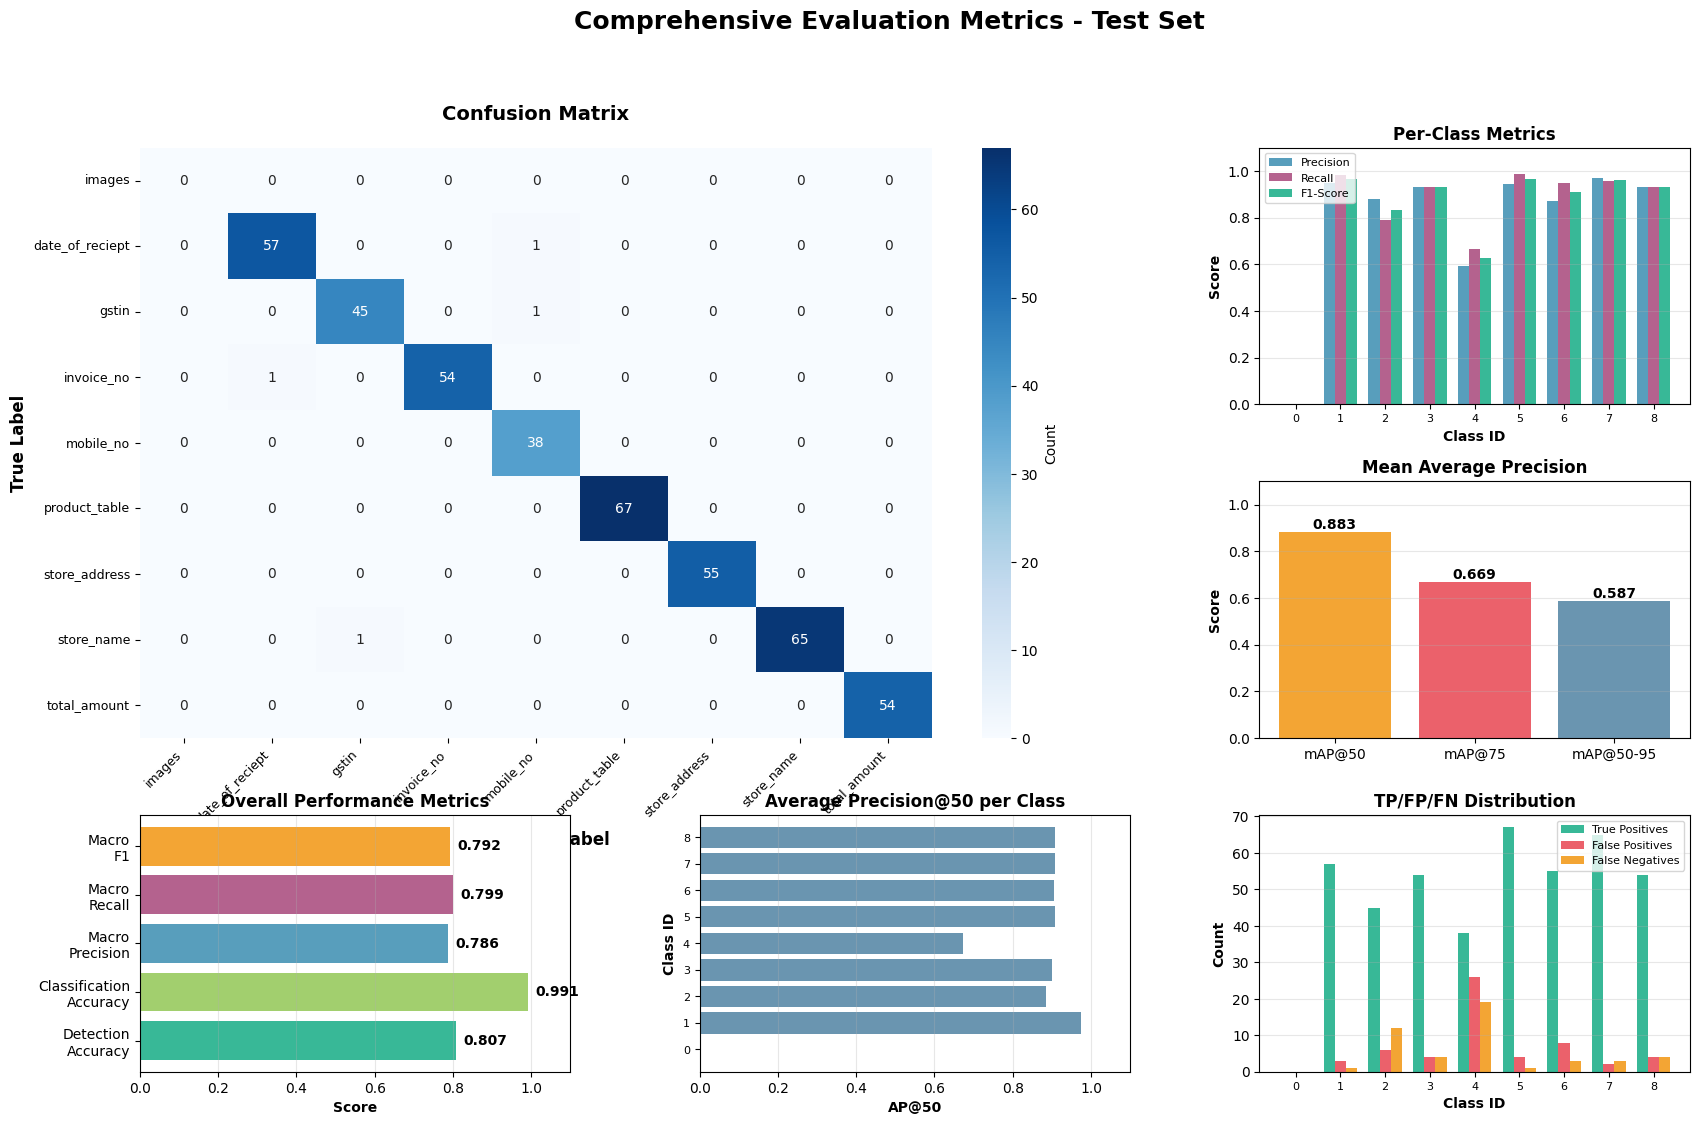


✓ Evaluation metrics visualizations saved!
  Saved to: output\evaluation_metrics.png


In [20]:
# Create comprehensive metrics visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0:2, 0:2])
cm = metrics['confusion_matrix']
sns.heatmap(
    cm, 
    annot=True, 
    fmt='g', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
    ax=ax1,
    cbar_kws={'label': 'Count'}
)
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=9)

# 2. Per-Class Precision, Recall, F1
ax2 = fig.add_subplot(gs[0, 2])
class_indices = list(range(num_classes))
precision_values = [metrics['precision_per_class'][i] for i in class_indices]
recall_values = [metrics['recall_per_class'][i] for i in class_indices]
f1_values = [metrics['f1_per_class'][i] for i in class_indices]

x = np.arange(len(class_indices))
width = 0.25

ax2.bar(x - width, precision_values, width, label='Precision', color='#2E86AB', alpha=0.8)
ax2.bar(x, recall_values, width, label='Recall', color='#A23B72', alpha=0.8)
ax2.bar(x + width, f1_values, width, label='F1-Score', color='#06A77D', alpha=0.8)

ax2.set_xlabel('Class ID', fontsize=10, fontweight='bold')
ax2.set_ylabel('Score', fontsize=10, fontweight='bold')
ax2.set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(class_indices, fontsize=8)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 1.1])

# 3. mAP Values
ax3 = fig.add_subplot(gs[1, 2])
map_labels = ['mAP@50', 'mAP@75', 'mAP@50-95']
map_scores = [map_50, map_75, map_50_95]
colors = ['#F18F01', '#E63946', '#457B9D']

bars = ax3.bar(map_labels, map_scores, color=colors, alpha=0.8)
ax3.set_ylabel('Score', fontsize=10, fontweight='bold')
ax3.set_title('Mean Average Precision', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 1.1])
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Overall Metrics Summary
ax4 = fig.add_subplot(gs[2, 0])
metrics_labels = ['Detection\nAccuracy', 'Classification\nAccuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1']
metrics_values = [
    metrics['detection_accuracy'],
    metrics['classification_accuracy'],
    metrics['macro_precision'],
    metrics['macro_recall'],
    metrics['macro_f1']
]
colors_metrics = ['#06A77D', '#8BC34A', '#2E86AB', '#A23B72', '#F18F01']

bars = ax4.barh(metrics_labels, metrics_values, color=colors_metrics, alpha=0.8)
ax4.set_xlabel('Score', fontsize=10, fontweight='bold')
ax4.set_title('Overall Performance Metrics', fontsize=12, fontweight='bold')
ax4.set_xlim([0, 1.1])
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    ax4.text(value + 0.02, bar.get_y() + bar.get_height()/2.,
             f'{value:.3f}',
             ha='left', va='center', fontweight='bold', fontsize=10)

# 5. Per-Class AP@50
ax5 = fig.add_subplot(gs[2, 1])
ap_values = [class_aps_50.get(i, 0.0) for i in class_indices]
bars = ax5.barh(class_indices, ap_values, color='#457B9D', alpha=0.8)
ax5.set_xlabel('AP@50', fontsize=10, fontweight='bold')
ax5.set_ylabel('Class ID', fontsize=10, fontweight='bold')
ax5.set_title('Average Precision@50 per Class', fontsize=12, fontweight='bold')
ax5.set_yticks(class_indices)
ax5.set_yticklabels(class_indices, fontsize=8)
ax5.grid(True, alpha=0.3, axis='x')
ax5.set_xlim([0, 1.1])

# 6. TP, FP, FN Distribution
ax6 = fig.add_subplot(gs[2, 2])
tp_values = [metrics['tp_per_class'][i] for i in class_indices]
fp_values = [metrics['fp_per_class'][i] for i in class_indices]
fn_values = [metrics['fn_per_class'][i] for i in class_indices]

x = np.arange(len(class_indices))
width = 0.25

ax6.bar(x - width, tp_values, width, label='True Positives', color='#06A77D', alpha=0.8)
ax6.bar(x, fp_values, width, label='False Positives', color='#E63946', alpha=0.8)
ax6.bar(x + width, fn_values, width, label='False Negatives', color='#F18F01', alpha=0.8)

ax6.set_xlabel('Class ID', fontsize=10, fontweight='bold')
ax6.set_ylabel('Count', fontsize=10, fontweight='bold')
ax6.set_title('TP/FP/FN Distribution', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(class_indices, fontsize=8)
ax6.legend(fontsize=8, loc='upper right')
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Evaluation Metrics - Test Set', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(output_dir / 'evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation metrics visualizations saved!")
print(f"  Saved to: {output_dir / 'evaluation_metrics.png'}")

## 15. Detailed Metrics Analysis for Train, Validation, and Test Sets

Generate detailed metric plots (Box Precision, Box Recall, Box F1, Confusion Matrix, Labels Distribution) for all three datasets and save them in separate folders.

In [21]:
import os
from pathlib import Path

# Create output directories for each dataset
train_output_dir = output_dir / 'train_metrics'
valid_output_dir = output_dir / 'validation_metrics'
test_output_dir = output_dir / 'test_metrics'

train_output_dir.mkdir(exist_ok=True)
valid_output_dir.mkdir(exist_ok=True)
test_output_dir.mkdir(exist_ok=True)

print("="*80)
print("GENERATING DETAILED METRICS FOR ALL DATASETS")
print("="*80)

def generate_detailed_metrics(predictions, targets, dataset_name, save_dir, num_classes, class_names):
    """
    Generate comprehensive metrics and visualizations for a dataset.
    
    Args:
        predictions: Model predictions
        targets: Ground truth targets
        dataset_name: Name of the dataset (Train/Validation/Test)
        save_dir: Directory to save outputs
        num_classes: Number of classes
        class_names: List of class names
    """
    print(f"\n{'='*80}")
    print(f"Processing {dataset_name} Dataset")
    print(f"{'='*80}")
    
    # Calculate metrics at confidence threshold 0.5
    print(f"Calculating metrics for {dataset_name}...")
    dataset_metrics = calculate_metrics_at_threshold(
        predictions, 
        targets, 
        confidence_threshold=0.5, 
        iou_threshold=0.5,
        num_classes=num_classes
    )
    
    # Calculate mAP metrics
    map_50, class_aps_50 = calculate_map(predictions, targets, iou_threshold=0.5, num_classes=num_classes)
    
    # Extract per-class metrics
    box_precision = [dataset_metrics['precision_per_class'][i] for i in range(num_classes)]
    box_recall = [dataset_metrics['recall_per_class'][i] for i in range(num_classes)]
    box_f1 = [dataset_metrics['f1_per_class'][i] for i in range(num_classes)]
    box_ap = [class_aps_50.get(i, 0.0) for i in range(num_classes)]
    
    # Collect actual and predicted labels
    actual_labels = []
    predicted_labels = []
    
    for pred, target in zip(predictions, targets):
        conf_mask = pred['scores'] >= 0.5
        pred_labels = pred['labels'][conf_mask].numpy()
        gt_labels = target['labels'].numpy()
        
        actual_labels.extend(gt_labels)
        predicted_labels.extend(pred_labels)
    
    # 1. Box Precision Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(num_classes), box_precision, color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Precision', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Box Precision per Class', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, box_precision)):
        plt.text(bar.get_x() + bar.get_width()/2., value + 0.02,
                 f'{value:.3f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'box_precision.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Box Recall Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(num_classes), box_recall, color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Recall', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Box Recall per Class', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, box_recall)):
        plt.text(bar.get_x() + bar.get_width()/2., value + 0.02,
                 f'{value:.3f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'box_recall.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Box F1-Score Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(num_classes), box_f1, color='#06A77D', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Box F1-Score per Class', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, box_f1)):
        plt.text(bar.get_x() + bar.get_width()/2., value + 0.02,
                 f'{value:.3f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'box_f1_score.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Box AP@50 Plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(num_classes), box_ap, color='#F18F01', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Average Precision @IoU=0.5', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Box AP@50 per Class', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, box_ap)):
        plt.text(bar.get_x() + bar.get_width()/2., value + 0.02,
                 f'{value:.3f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'box_ap50.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Combined Precision, Recall, F1 Plot
    plt.figure(figsize=(16, 9))
    x = np.arange(num_classes)
    width = 0.25
    
    plt.bar(x - width, box_precision, width, label='Precision', color='#2E86AB', alpha=0.8, edgecolor='black')
    plt.bar(x, box_recall, width, label='Recall', color='#A23B72', alpha=0.8, edgecolor='black')
    plt.bar(x + width, box_f1, width, label='F1-Score', color='#06A77D', alpha=0.8, edgecolor='black')
    
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Box Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(x, [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.ylim([0, 1.1])
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(save_dir / 'box_metrics_combined.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 6. Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = dataset_metrics['confusion_matrix']
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='g', 
        cmap='Blues', 
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig(save_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 7. Actual Labels Distribution
    plt.figure(figsize=(14, 8))
    unique_actual, counts_actual = np.unique(actual_labels, return_counts=True)
    full_counts_actual = np.zeros(num_classes)
    for label, count in zip(unique_actual, counts_actual):
        if label < num_classes:
            full_counts_actual[label] = count
    
    bars = plt.bar(range(num_classes), full_counts_actual, color='#457B9D', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Actual Labels Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, full_counts_actual)):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2., value + max(full_counts_actual)*0.01,
                     f'{int(value)}',
                     ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'actual_labels_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 8. Predicted Labels Distribution
    plt.figure(figsize=(14, 8))
    unique_pred, counts_pred = np.unique(predicted_labels, return_counts=True)
    full_counts_pred = np.zeros(num_classes)
    for label, count in zip(unique_pred, counts_pred):
        if label < num_classes:
            full_counts_pred[label] = count
    
    bars = plt.bar(range(num_classes), full_counts_pred, color='#E63946', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Predicted Labels Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for idx, (bar, value) in enumerate(zip(bars, full_counts_pred)):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2., value + max(full_counts_pred)*0.01,
                     f'{int(value)}',
                     ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'predicted_labels_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 9. Actual vs Predicted Labels Comparison
    plt.figure(figsize=(16, 8))
    x = np.arange(num_classes)
    width = 0.35
    
    plt.bar(x - width/2, full_counts_actual, width, label='Actual', color='#457B9D', alpha=0.8, edgecolor='black')
    plt.bar(x + width/2, full_counts_pred, width, label='Predicted', color='#E63946', alpha=0.8, edgecolor='black')
    
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Count', fontsize=14, fontweight='bold')
    plt.title(f'{dataset_name} - Actual vs Predicted Labels', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(x, [class_names[i] for i in range(num_classes)], rotation=45, ha='right', fontsize=10)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(save_dir / 'labels_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save metrics to JSON
    metrics_summary = {
        'dataset': dataset_name,
        'total_images': len(predictions),
        'total_actual_labels': int(len(actual_labels)),
        'total_predicted_labels': int(len(predicted_labels)),
        'map_50': float(map_50),
        'detection_accuracy': float(dataset_metrics['detection_accuracy']),
        'classification_accuracy': float(dataset_metrics['classification_accuracy']),
        'macro_precision': float(dataset_metrics['macro_precision']),
        'macro_recall': float(dataset_metrics['macro_recall']),
        'macro_f1': float(dataset_metrics['macro_f1']),
        'per_class_metrics': {
            class_names[i]: {
                'precision': float(box_precision[i]),
                'recall': float(box_recall[i]),
                'f1_score': float(box_f1[i]),
                'ap_50': float(box_ap[i]),
                'actual_count': int(full_counts_actual[i]),
                'predicted_count': int(full_counts_pred[i]),
                'true_positives': int(dataset_metrics['tp_per_class'][i]),
                'false_positives': int(dataset_metrics['fp_per_class'][i]),
                'false_negatives': int(dataset_metrics['fn_per_class'][i])
            } for i in range(num_classes)
        }
    }
    
    with open(save_dir / f'{dataset_name.lower()}_metrics.json', 'w') as f:
        json.dump(metrics_summary, f, indent=2)
    
    print(f"\n✓ {dataset_name} metrics saved to: {save_dir}")
    print(f"  - Box Precision: {dataset_metrics['macro_precision']:.4f}")
    print(f"  - Box Recall: {dataset_metrics['macro_recall']:.4f}")
    print(f"  - Box F1-Score: {dataset_metrics['macro_f1']:.4f}")
    print(f"  - mAP@50: {map_50:.4f}")
    print(f"  - Detection Accuracy: {dataset_metrics['detection_accuracy']:.4f}")
    print(f"  - Classification Accuracy: {dataset_metrics['classification_accuracy']:.4f}")
    
    return metrics_summary


# Generate metrics for all datasets
print("\n" + "="*80)
print("STEP 1: Evaluating Training Dataset")
print("="*80)
print("Generating predictions for training set...")
train_predictions, train_targets = evaluate(model, train_loader, device)

train_metrics = generate_detailed_metrics(
    train_predictions, 
    train_targets, 
    'Training', 
    train_output_dir, 
    num_classes, 
    class_names
)

print("\n" + "="*80)
print("STEP 2: Processing Validation Dataset")
print("="*80)
valid_metrics = generate_detailed_metrics(
    val_predictions, 
    val_targets, 
    'Validation', 
    valid_output_dir, 
    num_classes, 
    class_names
)

print("\n" + "="*80)
print("STEP 3: Processing Test Dataset")
print("="*80)
test_metrics = generate_detailed_metrics(
    test_predictions, 
    test_targets, 
    'Test', 
    test_output_dir, 
    num_classes, 
    class_names
)

print("\n" + "="*80)
print("ALL DATASETS PROCESSED SUCCESSFULLY!")
print("="*80)
print(f"\nOutput directories:")
print(f"  Training metrics:   {train_output_dir}")
print(f"  Validation metrics: {valid_output_dir}")
print(f"  Test metrics:       {test_output_dir}")

print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
print(f"\n{'Metric':<30} {'Training':<15} {'Validation':<15} {'Test':<15}")
print("-" * 75)
print(f"{'mAP@50':<30} {train_metrics['map_50']:<15.4f} {valid_metrics['map_50']:<15.4f} {test_metrics['map_50']:<15.4f}")
print(f"{'Detection Accuracy':<30} {train_metrics['detection_accuracy']:<15.4f} {valid_metrics['detection_accuracy']:<15.4f} {test_metrics['detection_accuracy']:<15.4f}")
print(f"{'Classification Accuracy':<30} {train_metrics['classification_accuracy']:<15.4f} {valid_metrics['classification_accuracy']:<15.4f} {test_metrics['classification_accuracy']:<15.4f}")
print(f"{'Macro Precision':<30} {train_metrics['macro_precision']:<15.4f} {valid_metrics['macro_precision']:<15.4f} {test_metrics['macro_precision']:<15.4f}")
print(f"{'Macro Recall':<30} {train_metrics['macro_recall']:<15.4f} {valid_metrics['macro_recall']:<15.4f} {test_metrics['macro_recall']:<15.4f}")
print(f"{'Macro F1-Score':<30} {train_metrics['macro_f1']:<15.4f} {valid_metrics['macro_f1']:<15.4f} {test_metrics['macro_f1']:<15.4f}")
print("="*80)

print("\n✓ All detailed metrics generated and saved successfully!")

GENERATING DETAILED METRICS FOR ALL DATASETS

STEP 1: Evaluating Training Dataset
Generating predictions for training set...


Evaluating: 100%|██████████| 186/186 [03:48<00:00,  1.23s/it]




Processing Training Dataset
Calculating metrics for Training...

✓ Training metrics saved to: output\train_metrics
  - Box Precision: 0.8339
  - Box Recall: 0.8747
  - Box F1-Score: 0.8529
  - mAP@50: 0.9266
  - Detection Accuracy: 0.9225
  - Classification Accuracy: 0.9991

STEP 2: Processing Validation Dataset

Processing Validation Dataset
Calculating metrics for Validation...

✓ Training metrics saved to: output\train_metrics
  - Box Precision: 0.8339
  - Box Recall: 0.8747
  - Box F1-Score: 0.8529
  - mAP@50: 0.9266
  - Detection Accuracy: 0.9225
  - Classification Accuracy: 0.9991

STEP 2: Processing Validation Dataset

Processing Validation Dataset
Calculating metrics for Validation...

✓ Validation metrics saved to: output\validation_metrics
  - Box Precision: 0.7857
  - Box Recall: 0.7919
  - Box F1-Score: 0.7882
  - mAP@50: 0.9043
  - Detection Accuracy: 0.7989
  - Classification Accuracy: 0.9907

STEP 3: Processing Test Dataset

Processing Test Dataset
Calculating metrics f

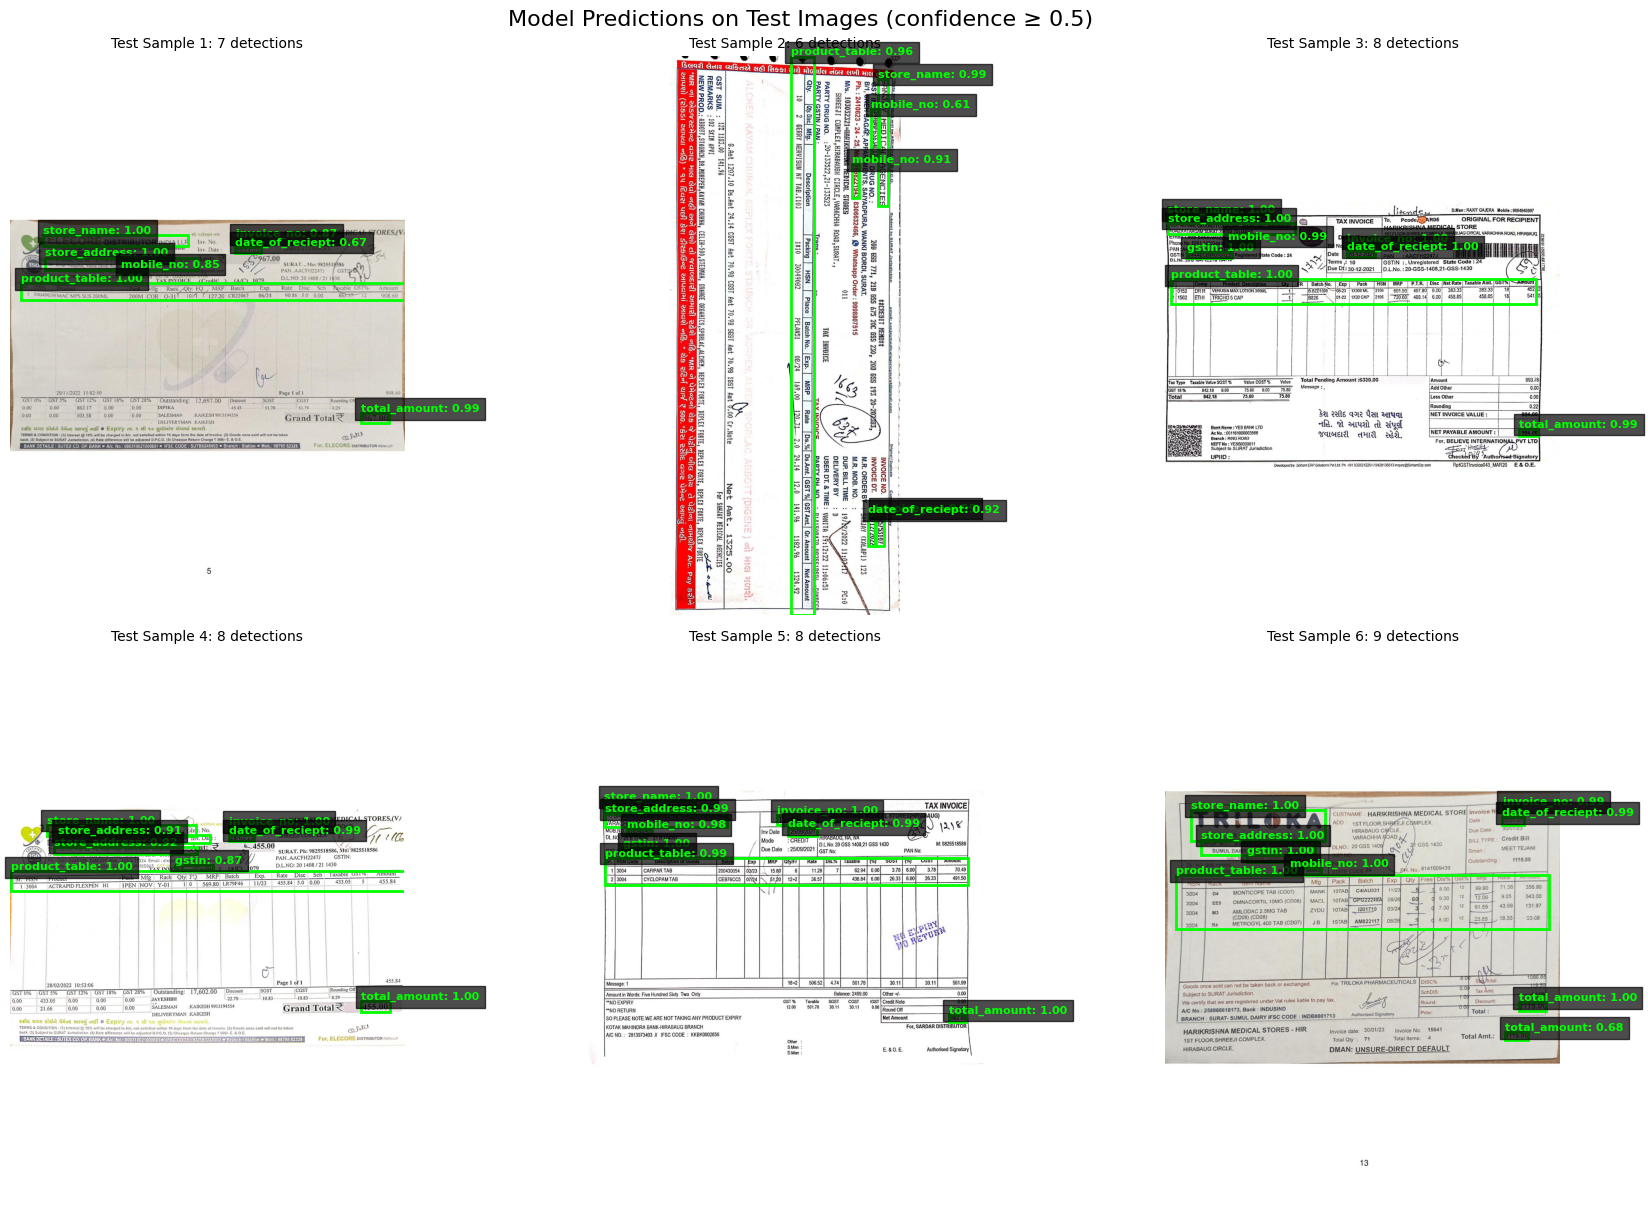


✓ Prediction visualizations displayed successfully!


In [22]:
def visualize_predictions(model, dataset, device, num_samples=6, confidence_threshold=0.5):
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, ax in enumerate(axes):
        # Get random sample
        random_idx = random.randint(0, len(dataset) - 1)
        img, target = dataset[random_idx]
        
        # Make prediction
        with torch.no_grad():
            prediction = model([img.to(device)])[0]
        
        # Convert image to numpy
        img_np = img.permute(1, 2, 0).cpu().numpy()
        
        # Plot image
        ax.imshow(img_np)
        
        # Filter predictions by confidence
        scores = prediction['scores'].cpu().numpy()
        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        
        high_conf_mask = scores >= confidence_threshold
        
        # Draw prediction boxes
        for box, label, score in zip(boxes[high_conf_mask], labels[high_conf_mask], scores[high_conf_mask]):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor='lime', linewidth=2
            )
            ax.add_patch(rect)
            
            # Add label text
            label_name = class_names[label] if label < len(class_names) else f"Class {label}"
            ax.text(
                x1, y1 - 5, f"{label_name}: {score:.2f}",
                color='lime', fontsize=8, weight='bold',
                bbox=dict(facecolor='black', alpha=0.7)
            )
        
        ax.axis('off')
        num_detections = high_conf_mask.sum()
        ax.set_title(f"Test Sample {idx + 1}: {num_detections} detections", fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'Model Predictions on Test Images (confidence ≥ {confidence_threshold})', 
                 fontsize=16, y=1.01)
    plt.savefig(output_dir / 'test_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_samples=6, confidence_threshold=0.5)

print("\n✓ Prediction visualizations displayed successfully!")